# FHIR Analytics with Spark

This notebook serves as a cleaned-up scratchbook for developing queries for processing
FHIR resources extracted from OpenMRS. This is part of the
[OpenMRS Analytics Engine](https://wiki.openmrs.org/pages/viewpage.action?pageId=235276342).
The notebook is based on [Apache Spark](https://spark.apache.org/) and the
output of ETL batch/streamin pipelines in the
[openmrs-fhir-analytics](https://github.com/GoogleCloudPlatform/openmrs-fhir-analytics)
repository.

Each section, shows examples of specific tasks for environment setup, loading, or processing data
in [PySpark](https://spark.apache.org/docs/latest/api/python/index.html).

In [1]:
print('Hellooo! We use PySpark!')

Hellooo! We use PySpark!


# Setting up Spark
We set up a local cluster with 20 nodes. This should be adjusted depending on the
machine on which the Jupyter server is running. Obviously the queries developed here
can be run on a truly distributed Spark cluster as well.

In [2]:
from typing import List
from datetime import datetime
import time
from pyspark import SparkConf
from pyspark.sql import SparkSession, DataFrame
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pandas

In [3]:
BASE_DIR='./test_files/'
BASE_PATIENT_URL='http://localhost:8099/openmrs/ws/fhir2/R4/Patient/'

In [4]:
conf = (SparkConf()
        .setMaster('local[20]')
        .setAppName('IndicatorsApp')
        # See example cells below where this setting is mentioned and needed.
        .set('spark.driver.memory', '10g')
        .set('spark.executor.memory', '2g')
        # Even if we don't explicitly `cache()`, it should happen automatically after shuffles.
        # So we need to be careful if we want to change the following (the defaults is 0.6).
        #
        # NOTE: It seems in some cases automatic caching after shuffle is not happening,
        # see examples/notes below!
        #
        #.set('spark.storage.memoryFraction', 0.2)
        .set('spark.authenticate', 'true')  # See: https://spark.apache.org/docs/latest/security.html
       )

In [5]:
# Starting up Spark
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# Loading Parquet files, sample aggregate queries, and Pandas conversion.
The `Patient, Encounter, Observation` directories in `./test_files/` contain Parquet files generated by
the batch pipeline from the test OpenMRS docker image in this repo. Many of these experiments
were also repeated on a large dataset by copying `Observation` resources 64 times, to verify
that the queries are still performant for millions of Observations.

In [6]:
start = time.time()
all_obs = spark.read.parquet(BASE_DIR + 'Observation')
# We can cache all_obs to make future uses faster.
# all_obs.cache()
end = time.time()
print('Elapsed time: ', end - start)

Elapsed time:  4.149174451828003


In [7]:
start = time.time()
print('Number of observations= ', all_obs.count())
end = time.time()
print('Elapsed time: ', end - start)

Number of observations=  72869
Elapsed time:  2.6360599994659424


In [10]:
all_patients = spark.read.parquet(BASE_DIR + '/Patient')
print('Number of patients= ', all_patients.count())

Number of patients=  1000


In [11]:
all_encounters = spark.read.parquet(BASE_DIR + '/Encounter')
print('Number of encounters= ', all_encounters.count())

Number of encounters=  11476


In [12]:
start_date='2020-12-09'
end_date='2020-12-10'

In [13]:
obs_filtered = all_obs.select(
      'subject.patientId', 'effective.dateTime', 'code', 'value').filter(
      all_obs.effective.dateTime > start_date).filter(
      all_obs.effective.dateTime < end_date)
print('Number of filtered observations= ', obs_filtered.count())

Number of filtered observations=  60


In [14]:
obs_filtered.head()

Row(patientId='be3dba27-61e6-46b9-bafe-09248f9e4ec7', dateTime='2020-12-09T09:04:12+00:00', code=Row(id=None, coding=[Row(id=None, system=None, version=None, code='159947AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', display='Visit Diagnoses', userSelected=None)], text=None), value=Row(quantity=None, codeableConcept=None, string='Dermatomycosis, Primary, Confirmed diagnosis', boolean=None, range=None, ratio=None, sampledData=None, attachment=None, time=None, dateTime=None, period=None))

In [15]:
# Note the predicate push-down to reading Parquet files.
obs_filtered.explain()

== Physical Plan ==
*(1) Project [subject#11.PatientId AS patientId#310, effective#13.dateTime AS dateTime#311, code#10, value#16]
+- *(1) Filter ((isnotnull(effective#13) AND (effective#13.dateTime > 2020-12-09)) AND (effective#13.dateTime < 2020-12-10))
   +- FileScan parquet [code#10,subject#11,effective#13,value#16] Batched: false, DataFilters: [isnotnull(effective#13), (effective#13.dateTime > 2020-12-09), (effective#13.dateTime < 2020-12-..., Format: Parquet, Location: InMemoryFileIndex[file:/usr/local/google/home/bashir/git_repos/bashir2/openmrs-fhir-warehouse/dwh..., PartitionFilters: [], PushedFilters: [IsNotNull(effective), GreaterThan(effective.dateTime,2020-12-09), LessThan(effective.dateTime,20..., ReadSchema: struct<code:struct<id:string,coding:array<struct<id:string,system:string,version:string,code:stri...




# `explode` and `groupBy`

Too flatten a collumn `C` with array elements, we can use `explode(C)` where each
row is repeated by the number of elements in its `C` column. Each new row will have
one of those elements in the new column.

`groupBy` is a similar concept to SQL `GROUP BY`.

In [18]:
obs_exploded_codes = obs_filtered.select(
    obs_filtered.patientId, obs_filtered.dateTime, obs_filtered.value,
    F.explode(obs_filtered.code.coding).alias('coding'))
obs_exploded_codes.head(2)

[Row(patientId='be3dba27-61e6-46b9-bafe-09248f9e4ec7', dateTime='2020-12-09T09:04:12+00:00', value=Row(quantity=None, codeableConcept=None, string='Dermatomycosis, Primary, Confirmed diagnosis', boolean=None, range=None, ratio=None, sampledData=None, attachment=None, time=None, dateTime=None, period=None), coding=Row(id=None, system=None, version=None, code='159947AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', display='Visit Diagnoses', userSelected=None)),
 Row(patientId='e2557413-13ef-476e-a858-5fcce5fe55c3', dateTime='2020-12-09T09:07:28+00:00', value=Row(quantity=None, codeableConcept=None, string='velit esse cillum dolore eu fugiat nulla pariatur.', boolean=None, range=None, ratio=None, sampledData=None, attachment=None, time=None, dateTime=None, period=None), coding=Row(id=None, system=None, version=None, code='162169AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', display='Text of encounter note', userSelected=None))]

In [19]:
grouped_obs = obs_exploded_codes.groupBy(['coding.code']).agg({'*':'count'})
print('Number of codes= ', grouped_obs.count())
grouped_obs.head(5)

Number of codes=  13


[Row(code='5088AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', count(1)=4),
 Row(code='5086AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', count(1)=4),
 Row(code='162169AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', count(1)=4),
 Row(code='1284AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', count(1)=6),
 Row(code='5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', count(1)=4)]

In [20]:
# Repeating the same cell with `all_obs` to check performance difference.
all_obs_codes = all_obs.select(
    all_obs.subject.patientId, all_obs.effective.dateTime, all_obs.value,
    F.explode(all_obs.code.coding).alias('coding'))
grouped_all_obs = all_obs_codes.groupBy([
    all_obs_codes.coding.code.alias('coding_code'),
    all_obs_codes.coding.display.alias('coding_display')]).agg(
    F.count('*').alias('num_obs'))
print('Number of codes= ', grouped_all_obs.count())
grouped_all_obs.head(5)

Number of codes=  13


[Row(coding_code='159394AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', coding_display='Diagnosis certainty', num_obs=7289),
 Row(coding_code='5092AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', coding_display='Arterial blood oxygen saturation (pulse oximeter)', num_obs=4857),
 Row(coding_code='5087AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', coding_display='Pulse', num_obs=4857),
 Row(coding_code='159947AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', coding_display='Visit Diagnoses', num_obs=7289),
 Row(coding_code='5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', coding_display='Weight (kg)', num_obs=4857)]

In [21]:
grouped_all_obs.show()

+--------------------+--------------------+-------+
|         coding_code|      coding_display|num_obs|
+--------------------+--------------------+-------+
|159394AAAAAAAAAAA...| Diagnosis certainty|   7289|
|5092AAAAAAAAAAAAA...|Arterial blood ox...|   4857|
|5087AAAAAAAAAAAAA...|               Pulse|   4857|
|159947AAAAAAAAAAA...|     Visit Diagnoses|   7289|
|5089AAAAAAAAAAAAA...|         Weight (kg)|   4857|
|5088AAAAAAAAAAAAA...|     Temperature (C)|   4857|
|159946AAAAAAAAAAA...|     Diagnosis order|   7289|
|5242AAAAAAAAAAAAA...|    Respiratory rate|   4857|
|5090AAAAAAAAAAAAA...|         Height (cm)|   4857|
|1284AAAAAAAAAAAAA...|        PROBLEM LIST|   7289|
|5085AAAAAAAAAAAAA...|Systolic blood pr...|   4857|
|162169AAAAAAAAAAA...|Text of encounter...|   4857|
|5086AAAAAAAAAAAAA...|Diastolic blood p...|   4857|
+--------------------+--------------------+-------+



# Conversion to Pandas DataFrame
Whenever a Spark DataFrame is small enough, we can simply convert it to a Pandas DataFrame
to make it easier to work with.

In [22]:
grouped_all_obs_P = grouped_all_obs.toPandas()
grouped_all_obs_P

,coding_code,coding_display,num_obs
0,159394AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,Diagnosis certainty,7289
1,5092AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,Arterial blood oxygen saturation (pulse oximeter),4857
2,5087AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,Pulse,4857
3,159947AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,Visit Diagnoses,7289
4,5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,Weight (kg),4857
5,5088AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,Temperature (C),4857
6,159946AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,Diagnosis order,7289
7,5242AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,Respiratory rate,4857
8,5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,Height (cm),4857
9,1284AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,PROBLEM LIST,7289


In [24]:
# Verifying that all observations have exactly one code.
grouped_all_obs_P['num_obs'].sum()

72869

# Restructure Observations and join with Patients
We can join Observation and Patient resources to get demographic information of each patient.
Note there is
[an open issue](https://github.com/GoogleCloudPlatform/openmrs-fhir-analytics/issues/55)
to fix the exported FHIR IDs in the ETL pipelines and drop the full server URL.

In [25]:
all_obs.head()

Row(id='http://localhost:8099/openmrs/ws/fhir2/R4/Observation/14c0fede-464f-425a-9289-8e127ec15b23', meta=None, implicitRules=None, language=None, text=None, contained=None, identifier=None, basedOn=None, status='final', category=[Row(id=None, coding=[Row(id=None, system='http://terminology.hl7.org/CodeSystem/observation-category', version=None, code='exam', display='Exam', userSelected=None)], text=None)], code=Row(id=None, coding=[Row(id=None, system=None, version=None, code='5242AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', display='Respiratory rate', userSelected=None)], text=None), subject=Row(DeviceId=None, GroupId=None, LocationId=None, PatientId='0f5c5b9a-c02f-4c07-a7b7-66705d7716bf', id=None, reference='Patient/0f5c5b9a-c02f-4c07-a7b7-66705d7716bf', identifier=None, display='Elizabeth Mitchell (OpenMRS ID: 1008YN)'), context=Row(EncounterId='984c7a46-1ca6-4617-a3fc-6f60bc11015b', EpisodeOfCareId=None, id=None, reference='Encounter/984c7a46-1ca6-4617-a3fc-6f60bc11015b', identifier=None, d

In [26]:
coded_obs = all_obs.select(
    all_obs.subject.patientId.alias('patientId'),
    all_obs.effective.dateTime.alias('dateTime'),
    all_obs.value,
    F.explode(all_obs.code.coding).alias('coding'))
coded_obs.head()

Row(patientId='0f5c5b9a-c02f-4c07-a7b7-66705d7716bf', dateTime='2020-11-04T08:41:04+00:00', value=Row(quantity=Row(id=None, value=Decimal('93.0000'), comparator=None, unit=None, system=None, code=None), codeableConcept=None, string=None, boolean=None, range=None, ratio=None, sampledData=None, attachment=None, time=None, dateTime=None, period=None), coding=Row(id=None, system=None, version=None, code='5242AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', display='Respiratory rate', userSelected=None))

In [27]:
all_patients.head()

Row(id='http://localhost:8099/openmrs/ws/fhir2/R4/Patient/9a80f9eb-3337-4c21-9c5a-f79a39c36d5a', meta=None, implicitRules=None, language=None, text=None, contained=None, identifier=[Row(id='25a5dd6d-e5e3-448e-a94e-8acae027cc9f', use='official', type=Row(id=None, coding=None, text='OpenMRS ID'), system=None, value='100VW7', period=None, assigner=None)], active=True, name=[Row(id='146f0aa9-ebf6-4e3e-9ada-55345ba0d1d4', use=None, text=None, family='Carter', given=['Robert'], prefix=None, suffix=None, period=None)], telecom=None, gender='male', birthDate='1996-02-15', deceased=Row(boolean=False, dateTime=None), address=[Row(id='df3dfc99-7487-45c0-b32e-6d818db27892', use='home', type=None, text=None, line=None, city='City7053', district=None, state='State7053', postalCode='17053', country='Country7053', period=None)], maritalStatus=None, multipleBirth=None, photo=None, contact=None, animal=None, communication=None, generalPractitioner=None, managingOrganization=None, link=None)

In [28]:
patient_name = all_patients.select(
    all_patients.id,
    all_patients.name[0].given[0].alias('given'),
    all_patients.name[0].family.alias('family')).withColumn(
      'core_id', F.regexp_replace('id', BASE_PATIENT_URL, ''))
patient_name.head()

Row(id='http://localhost:8099/openmrs/ws/fhir2/R4/Patient/9a80f9eb-3337-4c21-9c5a-f79a39c36d5a', given='Robert', family='Carter', core_id='9a80f9eb-3337-4c21-9c5a-f79a39c36d5a')

In [29]:
joined_obs = patient_name.join(
    coded_obs, patient_name.core_id == coded_obs.patientId)
print('Number of joined rows= ', joined_obs.count())
joined_obs.head()

Number of joined rows=  72869


Row(id='http://localhost:8099/openmrs/ws/fhir2/R4/Patient/0f5c5b9a-c02f-4c07-a7b7-66705d7716bf', given='Elizabeth', family='Mitchell', core_id='0f5c5b9a-c02f-4c07-a7b7-66705d7716bf', patientId='0f5c5b9a-c02f-4c07-a7b7-66705d7716bf', dateTime='2020-11-04T08:41:04+00:00', value=Row(quantity=Row(id=None, value=Decimal('93.0000'), comparator=None, unit=None, system=None, code=None), codeableConcept=None, string=None, boolean=None, range=None, ratio=None, sampledData=None, attachment=None, time=None, dateTime=None, period=None), coding=Row(id=None, system=None, version=None, code='5242AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', display='Respiratory rate', userSelected=None))

In [30]:
print('all_obs: {} coded_obs: {}'.format(all_obs.count(), coded_obs.count()))

all_obs: 72869 coded_obs: 72869


In [31]:
agg_obs = joined_obs.groupBy(
    [joined_obs.patientId, joined_obs.given, joined_obs.family, joined_obs.coding.code]).agg(
    {'*':'count', 'value.quantity.value':'max'}).withColumnRenamed('count(1)', 'num_obs')
agg_obs.head(2)

[Row(patientId='b2b4fb76-a39e-41a0-aaa8-141d97658217', given='Matthew', family='Thompson', coding[code]='159947AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', max(value.quantity.value AS `value`)=None, num_obs=12),
 Row(patientId='e7a0cf31-54fa-49fa-a5d9-2581493618d1', given='Nancy', family='Harris', coding[code]='5088AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', max(value.quantity.value AS `value`)=Decimal('38.0000'), num_obs=10)]

In [32]:
# Doing the same thing with a better API.
agg_obs = joined_obs.groupBy([
    joined_obs.patientId,
    joined_obs.given,
    joined_obs.family,
    joined_obs.coding.code.alias('coding_code')
]).agg(
    F.count('*').alias('num_obs'),
    F.max(joined_obs.value.quantity.value).alias('max_value'),
    F.min(joined_obs.dateTime).alias('min_date'),
    F.max(joined_obs.dateTime).alias('max_date')
)
print('Number of aggregated rows= ', agg_obs.count())
agg_obs.head(2)

Number of aggregated rows=  11869


[Row(patientId='0165cf25-8438-4d9c-b575-cd3913c66fbf', given='Michael', family='Lee', coding_code='162169AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', num_obs=8, max_value=None, min_date='2018-12-28T09:39:07+00:00', max_date='2020-09-25T09:04:09+00:00'),
 Row(patientId='05269fc4-5ad7-4eef-8b5d-03caa3818519', given='Richard', family='King', coding_code='162169AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', num_obs=4, max_value=None, min_date='2019-11-02T09:33:44+00:00', max_date='2020-08-28T09:47:45+00:00')]

# Making some functions out of these
Once we are done with step-by-step curing of a query, we can turn the whole process into
functions to be used in Python scripts ran through `spark-submit`.

In [33]:
def flatten_obs(obs: DataFrame) -> DataFrame:
  return obs.select(
      obs.subject.patientId.alias('patientId'),
      obs.effective.dateTime.alias('dateTime'),
      obs.value,
      F.explode(obs.code.coding).alias('coding'))

def aggregate_code_per_patient(
    flat_obs: DataFrame, code: str, start_date: str=None, end_date: str=None) -> DataFrame:
  if code is None:
    raise ValueError('`code` is expected to be a valid code string.')
  start_obs = flat_obs
  if start_date:
    start_obs = flat_obs.filter(flat_obs.dateTime > start_date)
  date_obs = start_obs
  if end_date:
    date_obs = start_obs.filter(start_obs.dateTime < end_date)
  code_obs = date_obs.filter(date_obs.coding.code == code)
  return code_obs.groupBy([
    flat_obs.patientId,
    flat_obs.coding.code.alias('coding_code')
  ]).agg(
    F.count('*').alias('num_obs'),
    F.min(flat_obs.value.quantity.value).alias('min_value'),
    F.max(flat_obs.value.quantity.value).alias('max_value'),
    F.min(flat_obs.dateTime).alias('min_date'),
    F.max(flat_obs.dateTime).alias('max_date')
  )

In [34]:
flat_obs = flatten_obs(all_obs)
flat_obs.count()

72869

In [35]:
# Sample aggregation for "Height".
aggregated_code_obs = aggregate_code_per_patient(flat_obs, '5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')
aggregated_code_obs.cache()
aggregated_code_obs.count()

913

In [37]:
# Without `cache()` in previous cell, the following `count()` takes another
# few seconds. With `cache` it is sub-second.
aggregated_code_obs.count()

913

In [38]:
aggregated_code_obs.head(2)

[Row(patientId='0a35552c-f4f7-4930-81a4-60d85ffcd6ba', coding_code='5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', num_obs=4, min_value=Decimal('106.0000'), max_value=Decimal('193.0000'), min_date='2019-03-29T08:57:19+00:00', max_date='2020-10-29T08:22:19+00:00'),
 Row(patientId='cc32422b-2f23-4ead-8612-b3dca499929d', coding_code='5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', num_obs=10, min_value=Decimal('27.0000'), max_value=Decimal('190.0000'), min_date='2019-03-20T08:21:29+00:00', max_date='2020-11-20T08:52:29+00:00')]

In [39]:
aggregated_code_obs_P = aggregated_code_obs.toPandas()
aggregated_code_obs_P.head()

,patientId,coding_code,num_obs,min_value,max_value,min_date,max_date
0,0a35552c-f4f7-4930-81a4-60d85ffcd6ba,5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,4,106.0,193.0,2019-03-29T08:57:19+00:00,2020-10-29T08:22:19+00:00
1,cc32422b-2f23-4ead-8612-b3dca499929d,5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,10,27.0,190.0,2019-03-20T08:21:29+00:00,2020-11-20T08:52:29+00:00
2,f16b5191-af47-4c5a-b9ca-71e0a4365824,5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,7,56.0,206.0,2019-05-31T08:17:28+00:00,2020-08-18T08:09:27+00:00
3,124d1b17-d3f8-4366-91d5-f66eef64f030,5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,6,42.0,204.0,2019-06-15T08:50:06+00:00,2020-09-24T08:52:06+00:00
4,393d07ea-a310-40fc-9f29-d5b91e1b2675,5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,2,29.0,186.0,2019-11-22T08:54:40+00:00,2020-08-08T09:00:41+00:00


<AxesSubplot:xlabel='min_value', ylabel='max_value'>

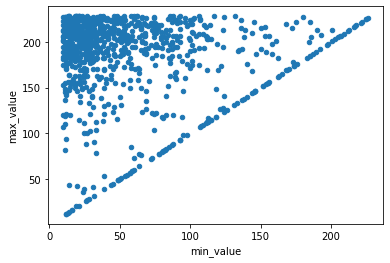

In [40]:
# This is just to showcase conversion to Pandas and graph functionality; the
# data has no realistic meaning as they are randomly generated (height values).
aggregated_code_obs_P.plot(kind='scatter', x='min_value', y='max_value')

# Extracting all observations for each patient
A handy view of the data, is to group all observations for each patient in a row.
For each observation code, we calculate some aggregates. To have all observations
gathered in the same patient row, we can use `pivot()`.

In [41]:
flat_obs.head()

Row(patientId='0f5c5b9a-c02f-4c07-a7b7-66705d7716bf', dateTime='2020-11-04T08:41:04+00:00', value=Row(quantity=Row(id=None, value=Decimal('93.0000'), comparator=None, unit=None, system=None, code=None), codeableConcept=None, string=None, boolean=None, range=None, ratio=None, sampledData=None, attachment=None, time=None, dateTime=None, period=None), coding=Row(id=None, system=None, version=None, code='5242AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', display='Respiratory rate', userSelected=None))

In [42]:
test_pivot = flat_obs.groupBy([
    flat_obs.patientId
]).pivot('coding.code').agg(
    F.min(flat_obs.value.quantity.value),
    F.max(flat_obs.value.quantity.value)
)
test_pivot.head()

Row(patientId='6836c26e-3ef9-4e4c-9ad6-bb5420964dce', 1284AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_min(value.quantity.value)=None, 1284AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_max(value.quantity.value)=None, 159394AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_min(value.quantity.value)=None, 159394AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_max(value.quantity.value)=None, 159946AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_min(value.quantity.value)=None, 159946AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_max(value.quantity.value)=None, 159947AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_min(value.quantity.value)=None, 159947AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_max(value.quantity.value)=None, 162169AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_min(value.quantity.value)=None, 162169AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_max(value.quantity.value)=None, 5085AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_min(value.quantity.value)=Decimal('35.0000'), 5085AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_max(value.quantity.value)=Decimal('245.0000'), 5086AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_min(value.quantity.value)=Decimal('17.0000'), 5086AA

In [43]:
def flatten_obs(obs: DataFrame) -> DataFrame:
  return obs.select(
      obs.subject.patientId.alias('patientId'),
      obs.effective.dateTime.alias('dateTime'),
      obs.value,
      F.explode(obs.code.coding).alias('coding'))

def aggregate_all_codes_per_patient(
    obs: DataFrame,
    codes: List[str]=None,
    start_date: str=None,
    end_date: str=None) -> DataFrame:
  flat_obs = flatten_obs(obs)
  start_obs = flat_obs
  if start_date:
    start_obs = flat_obs.filter(flat_obs.dateTime > start_date)
  date_obs = start_obs
  if end_date:
    date_obs = start_obs.filter(start_obs.dateTime < end_date)
  code_obs = date_obs
  if codes:
    code_obs = date_obs.filter(date_obs.coding.code.isin(codes))
  return date_obs.groupBy([
    flat_obs.patientId,
  ]).pivot('coding.code', values=codes).agg(
      F.count('*').alias('num_obs'),
      F.min(flat_obs.value.quantity.value).alias('min_value'),
      F.max(flat_obs.value.quantity.value).alias('max_value'),
      F.min(flat_obs.dateTime).alias('min_date'),
      F.max(flat_obs.dateTime).alias('max_date')
  )

In [44]:
agg_obs = aggregate_all_codes_per_patient(all_obs, codes=[
    '5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA',
    '5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'])
# This can also cause OOM errors if we use the default 1GB of spark.driver.memory.
agg_obs.head()

Row(patientId='0213330f-8b33-4bad-83c8-b5fd0c180b3b', 5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_num_obs=3, 5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_min_value=Decimal('176.0000'), 5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_max_value=Decimal('238.0000'), 5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_min_date='2019-03-30T08:37:06+00:00', 5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_max_date='2020-09-08T07:51:06+00:00', 5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_num_obs=3, 5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_min_value=Decimal('100.0000'), 5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_max_value=Decimal('172.0000'), 5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_min_date='2019-03-30T08:37:06+00:00', 5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_max_date='2020-09-08T07:51:06+00:00')

<AxesSubplot:title={'center':'Maximum Height vs Minimum Weight'}, xlabel='mimum weight', ylabel='maximum height'>

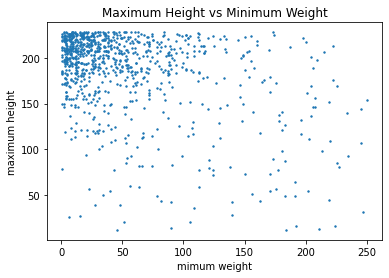

In [45]:
# Plotting maximum height as a function of minimum weight.
# Note random data!
agg_obs_P = agg_obs.toPandas()
agg_obs_P.plot(
    kind='scatter',
    x='5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_min_value', xlabel='mimum weight',
    y='5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_max_value', ylabel='maximum height',
    s=2, title='Maximum Height vs Minimum Weight')

# Joining with patient demographic data
For calculating PEPFAR indicators we need to do disaggregations based on geneder , age, etc. 

In [46]:
patients = all_patients
base_patient_url = BASE_PATIENT_URL

In [47]:
patients.head()

Row(id='http://localhost:8099/openmrs/ws/fhir2/R4/Patient/9a80f9eb-3337-4c21-9c5a-f79a39c36d5a', meta=None, implicitRules=None, language=None, text=None, contained=None, identifier=[Row(id='25a5dd6d-e5e3-448e-a94e-8acae027cc9f', use='official', type=Row(id=None, coding=None, text='OpenMRS ID'), system=None, value='100VW7', period=None, assigner=None)], active=True, name=[Row(id='146f0aa9-ebf6-4e3e-9ada-55345ba0d1d4', use=None, text=None, family='Carter', given=['Robert'], prefix=None, suffix=None, period=None)], telecom=None, gender='male', birthDate='1996-02-15', deceased=Row(boolean=False, dateTime=None), address=[Row(id='df3dfc99-7487-45c0-b32e-6d818db27892', use='home', type=None, text=None, line=None, city='City7053', district=None, state='State7053', postalCode='17053', country='Country7053', period=None)], maritalStatus=None, multipleBirth=None, photo=None, contact=None, animal=None, communication=None, generalPractitioner=None, managingOrganization=None, link=None)

In [48]:
flat_patients = patients.select(
    patients.id, patients.birthDate, patients.gender).withColumn(
    'actual_id', F.regexp_replace('id', base_patient_url, ''))
flat_patients.head()

Row(id='http://localhost:8099/openmrs/ws/fhir2/R4/Patient/9a80f9eb-3337-4c21-9c5a-f79a39c36d5a', birthDate='1996-02-15', gender='male', actual_id='9a80f9eb-3337-4c21-9c5a-f79a39c36d5a')

In [49]:
patient_agg_obs = flat_patients.join(agg_obs, flat_patients.actual_id == agg_obs.patientId)
patient_agg_obs.cache()
patient_agg_obs.head()

Row(id='http://localhost:8099/openmrs/ws/fhir2/R4/Patient/0213330f-8b33-4bad-83c8-b5fd0c180b3b', birthDate='1980-09-07', gender='female', actual_id='0213330f-8b33-4bad-83c8-b5fd0c180b3b', patientId='0213330f-8b33-4bad-83c8-b5fd0c180b3b', 5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_num_obs=3, 5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_min_value=Decimal('176.0000'), 5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_max_value=Decimal('238.0000'), 5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_min_date='2019-03-30T08:37:06+00:00', 5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_max_date='2020-09-08T07:51:06+00:00', 5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_num_obs=3, 5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_min_value=Decimal('100.0000'), 5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_max_value=Decimal('172.0000'), 5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_min_date='2019-03-30T08:37:06+00:00', 5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_max_date='2020-09-08T07:51:06+00:00')

In [50]:
patient_agg_obs.count()

913

In [60]:
def find_age_band(birth_date: str) -> str:
    birth = datetime.strptime(birth_date, '%Y-%m-%d')
    age = int((datetime.today() - birth).days / 365.25)
    if age < 1:
        return '0-1'
    if age <= 4:
        return '1-4'
    if age <= 9:
        return '5-9'
    if age <= 14:
        return '10-14'
    if age <= 19:
        return '15-19'
    if age <= 24:
        return '20-24'
    if age <= 49:
        return '25-49'
    return '50+'

print(find_age_band('1981-01-07'))
print(find_age_band('1996-01-07'))
print(find_age_band('1996-05-07'))

25-49
25-49
20-24


In [61]:
# Depending on the disaggregation buckets, each patient should to be
# counted in multiple buckets. This function create the list of buckets.

def agg_buckets(birth_date: str, gender: str) -> List[str]:
    age_band = find_age_band(birth_date)
    return [age_band + '_' + gender, 'ALL-AGES_' + gender,
            age_band + '_ALL-GENDERS', 'ALL-AGES_ALL-GENDERS']

print(agg_buckets('1981-01-07', 'female'))

['25-49_female', 'ALL-AGES_female', '25-49_ALL-GENDERS', 'ALL-AGES_ALL-GENDERS']


In [62]:
#find_age_band_udf = F.UserDefinedFunction(lambda x: find_age_band(x), T.StringType())
agg_buckets_udf = F.UserDefinedFunction(lambda a, g: agg_buckets(a, g), T.ArrayType(T.StringType()))
num_patients = patient_agg_obs.count()
VL_code = '5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'
VL_df = patient_agg_obs.withColumn(
    'sup_VL', patient_agg_obs[VL_code + '_max_value'] < 150).withColumn(
    'agg_buckets', agg_buckets_udf(patient_agg_obs['birthDate'], patient_agg_obs['gender'])
)
VL_df.head()

Row(id='http://localhost:8099/openmrs/ws/fhir2/R4/Patient/0213330f-8b33-4bad-83c8-b5fd0c180b3b', birthDate='1980-09-07', gender='female', actual_id='0213330f-8b33-4bad-83c8-b5fd0c180b3b', patientId='0213330f-8b33-4bad-83c8-b5fd0c180b3b', 5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_num_obs=3, 5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_min_value=Decimal('176.0000'), 5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_max_value=Decimal('238.0000'), 5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_min_date='2019-03-30T08:37:06+00:00', 5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_max_date='2020-09-08T07:51:06+00:00', 5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_num_obs=3, 5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_min_value=Decimal('100.0000'), 5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_max_value=Decimal('172.0000'), 5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_min_date='2019-03-30T08:37:06+00:00', 5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA_max_date='2020-09-08T07:51:06+00:00', sup_VL=False, agg_buckets=['25-49_female', 'ALL-AGES_female', '25-49_ALL-GENDERS', 'ALL-AGES_A

In [63]:
num_patients = VL_df.count()
num_patients

913

In [64]:
VL_agg_P = VL_df.select(
    VL_df.sup_VL,
    F.explode(VL_df.agg_buckets).alias('agg_bucket')).groupBy(
    'sup_VL', 'agg_bucket').agg(
    F.count('*').alias('count')).toPandas().sort_values(
    ['agg_bucket', 'sup_VL'])
VL_agg_P['ratio'] = VL_agg_P['count']/num_patients
VL_agg_P

,sup_VL,agg_bucket,count,ratio
13,False,1-4_ALL-GENDERS,24,0.026287
39,True,1-4_ALL-GENDERS,4,0.004381
23,False,1-4_female,14,0.015334
29,True,1-4_female,1,0.001095
14,False,1-4_male,10,0.010953
21,True,1-4_male,3,0.003286
47,False,10-14_ALL-GENDERS,34,0.037240
25,True,10-14_ALL-GENDERS,4,0.004381
41,False,10-14_female,15,0.016429
3,True,10-14_female,2,0.002191


In [65]:
VL_agg_P[VL_agg_P['agg_bucket'] == 'ALL-AGES_ALL-GENDERS']

,sup_VL,agg_bucket,count,ratio
28,False,ALL-AGES_ALL-GENDERS,768,0.841183
6,True,ALL-AGES_ALL-GENDERS,145,0.158817


In [57]:
# It seems better not to mix the RDD API with DataFrame but an alternative
# solution for counting one row in multiple buckets was to use rdd.flatMap.
test = VL_df.rdd.flatMap(lambda x: [x['birthDate'], x[2]])
test.collect()[0:10]

['1980-09-07',
 'female',
 '2004-03-27',
 'male',
 '1963-12-18',
 'female',
 '1994-07-11',
 'female',
 '1998-02-20',
 'female']